# Forest Fire Burn Area Prediction
Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The purpose of this notebook is to predict the forest fire burn area. This is a popular regression dataset found on both Kaggle and the UCI Machine Learning Repository. The two data sets are identical, but the one used here was downloaded from UCI. The forest fire weather index (FWI) system features FFMC, DMC, DC and ISI are described [here](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi). The target variable is burn area, which can be predicted by a set of feature variables listed below. The data to be used is already pre-processed by checking for missing values, outliers and converting the categorical features numerical values. However, there are unbalanced features that must be addressed, the target has nearly a 50% proportion of zeros, and the features are generally not Gaussian distributed. 

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 0 to 11
4. day - day of the week: 0 to 6
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84

Notes:
- First, try predicting burn area directly
    - Resample to account for feature imbalances
    - Eliminate day category as it is likely just noise
    - Maybe eliminate rain due to high number of zeros
- Second, split the problem into classification (predict whether a fire occurs) and regression (if there is a fire, predict the burn area)
    - Can represent the results as a joint probability see [here](https://datascience.stackexchange.com/questions/25576/best-method-to-deal-with-too-many-zeroes-in-regression-problem)
    - Reference for two part model: "[Analyzing Skewed Continuous Outcomes With Many Zeros: A Tutorial for Social Work and Youth Prevention Science Researchers](https://doi.org/10.1086/701235)"
- Look at the effects of whitening to improve model performance
- Maximize predictive capabilities of model
    - Do some research to determine which model is best suited to the task
    
    
Process
- Split into train and test sets before balancing data, to avoid 
- Upsample minority data to match frequency of August and September
    - Danger with this is some months only have a single data point, so it's over fitting the fuck outta those points
- Upsample a little bit and then split the data into multiple sets
- Don't upsample at all and then 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from my_regression import whitening_transform


In [2]:
def weighted_upsample(data, feature, n_samples=500, seed=123456, plot=True):
    """ Upsamples the data, weighted by the distribution of a given feature.
    
    This function attempts to balance the given dataset by upsampling based on
    an inverse relationship to the current distribution of a particular feature.
    Data points associated with frequently occuring insatances of a feature are
    less likely to be sampled, and vice versa. For example, if there are two
    categories, with one occuring 4 times and the other occurring once, the
    minority feature will be four times as likel to be sampled. The weights
    are recalculated after each sample is added to the dataset.
    
    This function currently only works with discretized or categorical features.
    There is no stopping condition, and the number of samples must be chosen.
    Therefore, if an insufficient number is chosen, the data set will not become
    balanced.
    
    Parameters
        data: DataFrame = the dataset to be upsampled (and/or balanced)
        feature: str = the feature whose distribution determines the weighting
        n_samples: int = the number of samples to add to the dataset
        seed: int = the random seed used to make the process repeatable
        plot: bool = True -> plots a histogram of the feature distribution
        
    Returns
        resampled_data: DataFrame = the upsampled/balanced dataset
    """
    
    counts = len(data[feature].value_counts())
    month_wts = np.zeros(counts)
    upsampled_data = data.copy()
    np.random.seed(seed)
    for i in range(n_samples):
        # Weight the sampling by the current distribution
        counts = upsampled_data[feature].value_counts()
        ind_sort = list(counts.index.values.astype(int))
        month_wts[ind_sort] = (1 / counts.values) / (1 / counts.values).sum()

        # Select a month to sample from and resample from that selection
        month_id = np.random.choice(12, p=month_wts)
        month_data = upsampled_data.loc[upsampled_data[feature] == month_id]
        new_sample = resample(month_data, n_samples=1)

        # Append the new sample to the existing data
        upsampled_data = pd.concat([upsampled_data, new_sample], ignore_index=True)

    if plot:
        sns.countplot(x=upsampled_data[feature])
        
    return upsampled_data


def resample_ensemble(major_class, minor_class, n_folds=5, seed=123456):
    """ Splits unbalanced data into subsets (folds).
    
    In each fold, the minority class is fully represented, while the majority
    class (the one with high frequency feature occurrences) is split into folds.
    This is an ensemble because the model can then be trained on each individual
    subset, and the final answer can be the average of the differently trained
    models.
    
    Parameters
        major_class: nd.array (observations, features) = the data corresponding
            to the high frequency class(es)
        minor_class: nd.array (observations, features) = the data corresponding
            to the low frequency class(es)
        n_folds:int = the number of subsets to split the majority class into
        seed: int = the random seed used to make the process repeatable
        
    Returns
        folds: list(tuples) = the X and y data for each resampled subset
    """
    # Change to use data frames https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    
    # np.random.seed(seed)
    # np.random.shuffle(major_class)
    major_class.sample(frac=1, random_state=seed)
    fold_sz = len(major_class) // n_folds
    folds = []
    for k in range(n_folds):
        # major_fold = major_class[k * fold_sz:(k + 1) * fold_sz, :]
        # comb_data = np.vstack((minor_class, major_fold))
        # this_fold = comb_data[:, :-1], comb_data[:, -1]
        major_fold = major_class.iloc[k * fold_sz:(k + 1) * fold_sz, :]
        comb_data = pd.concat([minor_class, major_fold], axis=0)
        this_fold = comb_data.iloc[:, :-1], comb_data.iloc[:, -1]
        folds.append(this_fold)
    
        # sns.countplot(x=this_fold[0][:, 2], color=f'C{k}')
        # plt.show()
        
    return folds


def BinaryEncoder(data, col_ls):
    """ Encodes numericized categorical data as a set of binary columns.
    
    Categorical data needs to be encoded such that it is usable by ML algorithms.
    However, large numbers of categories in one-hot encoding leads to large
    feature dimensions. Therefore, this function uses binary encoding to reduce
    the space required to encode these features. Binary encoding avoids the issue
    of collisions, which occurs with other methods such as hash encoding.
    
    The length of the binary encoding required is calculated based on the number
    of unique categories for each column. The encoded columns are concatenated
    at the beginning of the data frame.
    
    This function requires that the
    categorical data has already been converted to be represented by a range of
    ints. This will be updated in later versions of the function.
    
    Paramters
        data: DataFrame = all data
        col_ls: list = list of categorical column names to be encoded
        
    Returns
        enc_data: DataFrame = categorical data encoded columns
        n_enc_col: int = total number of encoded columns in output
    """
    
    # Initialize a label encoder for dealing with non-numericized categories
    # le = LabelEncoder()
    
    n_enc_col = 0
    for i, col in enumerate(col_ls):
        # # Convert category names to a range of integers
        # if (data[col].dtype == 'object') or (data[col].dtype == 'category'):
        #     data[col] = le.fit_transform(data[col])
        
        # Find the number of unique categories
        n_cats = len(data[col].unique())
        
        # Determine the length of the binary encoding
        n_dig = len(format(data[col].max(), 'b'))
        n_enc_col += n_dig
        
        # Calculate the encoding for each category
        bin_enc = np.zeros((len(data), n_dig), dtype=int)
        for n in range(n_cats):
            inds = data.loc[data[col] == n].index
            bin_val = [int(x) for x in format(n, f'0{n_dig}b')]
            bin_enc[inds, :] = bin_val
            
        # Assign new column names
        col_names = []
        for d in range(n_dig):
            col_names.append(f'month{d}')
        
        # Concatenate the encoded columns
        if i == 0:
            enc_data = pd.DataFrame(bin_enc, columns=col_names)
        else:
            enc_data = pd.concat([pd.DataFrame(bin_enc, columns=col_names), enc_data], axis=1)
        
    return enc_data, n_enc_col


In [3]:
# Load the pre-processed data
data = pd.read_csv('data/forestfires_preprocessed.csv')

# Eliminate the day and rain categories
data.drop(columns=['day', 'rain'], inplace=True)


In [4]:
# Encode the categorical 'month' feature using binary encoding
cat_cols = ['month']
enc_data, n_enc_col = BinaryEncoder(data, cat_cols)
# display(enc_data.head(n=10))
data = pd.concat([enc_data, data], axis=1)


In [5]:
# Split into training and test sets
data_nd = data.values
X_nd, y_nd = data_nd[:, :-1], data_nd[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_nd, y_nd, test_size=0.2, random_state=66)

# Recombine into data frames for further processing
data_train = pd.DataFrame(np.hstack((X_train, y_train[:, None])))
data_train.columns = data.columns
data_test = pd.DataFrame(np.hstack((X_test, y_test[:, None])))
data_test.columns = data.columns
# display(data_train)
# display(data_test)


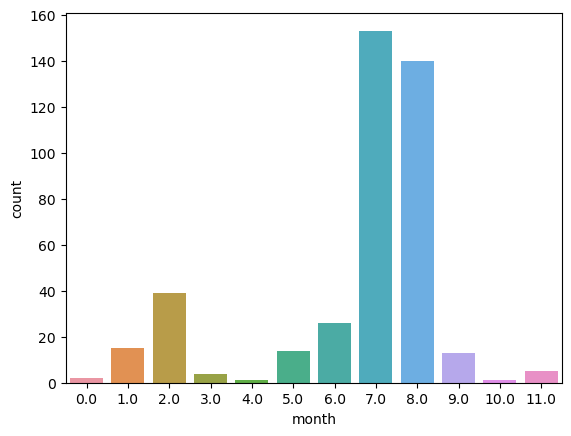

In [6]:
# Look at the distribution of months in the training data
sns.countplot(x=data_train.month);


Index(['month0', 'month1', 'month2', 'month3', 'X', 'Y', 'month', 'FFMC',
       'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'],
      dtype='object')

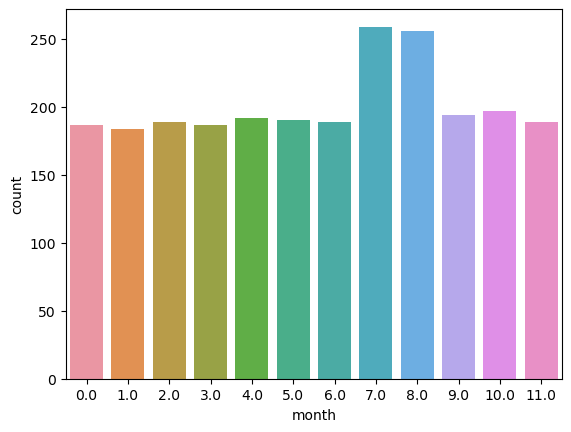

In [7]:
# Balance the dataset by resampling, weighted by frequency
resamp_train1 = weighted_upsample(data_train, 'month', n_samples=2000, plot=True)
X_train_re1, y_train_re1 = resamp_train1.iloc[:, :-1], resamp_train1.iloc[:, -1]
display(X_train_re1.columns)

# Balance the dataset by splitting the high frequency data into a training ensemble
#  Idea from here: https://www.kaggle.com/questions-and-answers/201922
major2 = data_train.loc[(data_train.month == 7) | (data_train.month == 8)]
minor2 = data_train.loc[(data_train.month != 7) & (data_train.month != 8)]
resamp_train2 = resample_ensemble(major2, minor2, n_folds=5)

# Balance the dataset by first upsampling, and then splitting into a resampled ensemble
resamp_train3 = weighted_upsample(data_train, 'month', n_samples=300, plot=False)
major3 = resamp_train3.loc[(resamp_train3.month == 7) | (resamp_train3.month == 8)]
minor3 = resamp_train3.loc[(resamp_train3.month != 7) & (resamp_train3.month != 8)]
resamp_train3 = resample_ensemble(major3, minor3, n_folds=3)
# for Xt, yt in resamp_train3:
#     sns.countplot(x=Xt[:, 2])
#     plt.show()

all_resamp_data = [[(X_train_re1, y_train_re1)], resamp_train2, resamp_train3]


In [8]:
# Whiten the resampled training data
all_resamp_white_train  = []
for i, re_data in enumerate(all_resamp_data):
    if len(re_data) > 1:
        ens_resamp_white_train = []
        for j, (Xt, yt) in enumerate(re_data):
            # Select only the numerical data
            new_Xt = Xt.drop(columns=cat_cols)
            num_Xt = new_Xt.iloc[:, n_enc_col:]

            # Centering
            num_Xt_center = num_Xt - num_Xt.mean(axis=0)

            # Whitening
            W = whitening_transform(num_Xt_center)
            num_X_white_train = (W @ num_Xt_center.T).T

            # Recombine with categorical data
            X_white_train = pd.concat([new_Xt.iloc[:, :n_enc_col], num_X_white_train], axis=1)
            X_white_train.columns = new_Xt.columns
            # display(X_white_train)
            
            # Append to ensemble list
            ens_resamp_white_train.append((X_white_train, yt))
            
        # Append to resample list
        all_resamp_white_train.append(ens_resamp_white_train)
    else:
        # Select only the numerical data
        Xt, yt = re_data[i][0], re_data[i][1]
        new_Xt = Xt.drop(columns=cat_cols)
        num_Xt = new_Xt.iloc[:, n_enc_col:]
        
        # Centering
        num_Xt_center = num_Xt - num_Xt.mean(axis=0)

        # Whitening
        W = whitening_transform(num_Xt_center)
        num_X_white_train = (W @ num_Xt_center.T).T

        # Recombine with categorical data
        X_white_train = pd.concat([new_Xt.iloc[:, :n_enc_col], num_X_white_train], axis=1)
        X_white_train.columns = new_Xt.columns
        # display(X_white_train)

        # Append to resample list
        all_resamp_white_train.append([(X_white_train, yt)])
    

,0,1,2,3,4,5,6,7,8
count,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02
mean,9.381493e-16,6.126867e-16,-2.917540e-15,1.090886e-14,-5.399030e-16,-2.917431e-15,-1.490436e-15,3.238983e-15,-7.423938e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.172738e+00,-3.540376e+00,-1.363557e+00,-2.512980e+00,-6.364132e+00,-1.978750e+00,-2.571429e+00,-4.101450e+00,-2.270800e+00
25%,-9.210669e-01,-4.793545e-01,-6.377458e-01,-6.127328e-01,-6.082513e-01,-7.332775e-01,-7.513630e-01,-4.017955e-01,-8.063848e-01
50%,-2.418753e-01,-1.081428e-01,-2.890061e-01,6.804974e-02,-1.249496e-01,-2.621399e-01,-6.493251e-02,-6.032967e-02,-1.139663e-01
75%,1.105263e+00,5.256389e-01,3.254222e-01,6.549413e-01,6.988198e-01,3.971307e-01,5.501943e-01,4.942014e-01,6.021441e-01
max,2.110177e+00,2.009890e+00,3.375471e+00,3.460733e+00,3.678015e+00,9.648423e+00,2.608754e+00,6.937341e+00,3.634792e+00


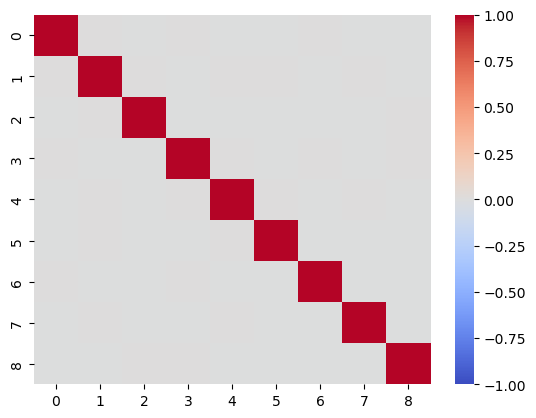

In [9]:
# Check whitening: covariance matrix should be identity
# plt_white_data = all_resamp_white_train[0][0][0]
sns.heatmap(np.cov(num_X_white_train.T), cmap='coolwarm', vmin=-1, vmax=1)

# # Visualize the data
# sns.pairplot(pd.DataFrame(num_X_white_train))

# num_data_train = np.hstack((num_X_white_train, y_train[:, None]))
# num_data_test = np.hstack((num_X_white_test, y_test[:, None]))
# num_data_white = pd.DataFrame(np.vstack((num_data_train, num_data_test)))
# display(num_data.tail(n=10))
# display(num_data_white.tail(n=10))
display(num_X_white_train.describe())
# display(pd.DataFrame(num_data_train).describe())


In [27]:
# Define a grid search to train and test the model
cv_split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=66)

# Random forest regressor
rand_forest_model = RandomForestRegressor(random_state=66, warm_start=True)
rand_forest_params = {'n_estimators': [100, 200, 400, 800],
                      'max_depth': [1, 2, 4],
                      'min_samples_leaf': [1, 5, 10],
                      'ccp_alpha': [0., 0.0005]}
rand_forest_grid = GridSearchCV(rand_forest_model, rand_forest_params, scoring='r2', n_jobs=-1, cv=cv_split)

# SVR
svr_model = SVR()
# svr_params = {'kernel': ['rbf'],
#               'gamma': [0.1, 0.5, 1],
#               'C': [10, 100, 500]}
svr_params = {'kernel': ['rbf'],
              'gamma': [1, 10, 100],
              'C': [10, 100, 500],
              'epsilon': [0.1, 0.5, 1]}
svr_grid = GridSearchCV(svr_model, svr_params, scoring='r2', n_jobs=-1, cv=cv_split)

# XGBoost
xgb_model = XGBRegressor(gamma=10, reg_lambda=100)
xgb_params = {'eta': [0.1, 0.3, 0.5],
              'max_depth': [1, 5, 10],
              'alpha': [0, 1, 10]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='r2', n_jobs=-1, cv=cv_split)

# # MLP regressor
# mlp_model = MLPRegressor(max_iter=1000, random_state=66, warm_start=True)
# mlp_params = {'activation': ['relu'],
#               'solver': ['sgd', 'adam'],
#               'alpha': [1e-4, 1e-3, 1e-2],
#               'learning_rate': ['constant', 'invscaling'],
#               'momentum': [0.5, 0.9, 1.]}
# # mlp_params = {'activation': ['identity', 'relu'],
# #               'solver': ['sgd', 'adam'],
# #               'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
# #               'learning_rate': ['constant', 'invscaling', 'adaptive'],
# #               'momentum': [0.1, 1, 10, 100]}
# mlp_grid = GridSearchCV(mlp_model, mlp_params, scoring='r2', n_jobs=-1, cv=cv_split)


In [28]:
grid_search = svr_grid
resamp_params = []
resamp_models = []
resamp_scores = []
for i, tmp_data in enumerate(all_resamp_white_train):
    if len(tmp_data) > 1:
        ens_params = []
        ens_scores = []
        ens_models = []
        for j, (Xt, yt) in enumerate(tmp_data):
            grid_search.fit(Xt, yt)
            print('done search')
            ens_params.append(grid_search.best_params_)
            ens_scores.append(grid_search.best_score_)
            ens_models.append(grid_search.best_estimator_)
        resamp_params.append(ens_params)
        resamp_models.append(ens_models)
        resamp_scores.append(ens_scores)
    else:
        grid_search.fit(tmp_data[0][0], tmp_data[0][1])
        print('done search')
        resamp_params.append(grid_search.best_params_)
        resamp_models.append(grid_search.best_estimator_)
        resamp_scores.append(grid_search.best_score_)
        
print(resamp_params)
print(resamp_models)
print(resamp_scores)
        

done search
done search
done search
done search
done search
done search
done search
done search
done search
[{'C': 500, 'epsilon': 0.1, 'gamma': 100, 'kernel': 'rbf'}, [{'C': 10, 'epsilon': 1, 'gamma': 10, 'kernel': 'rbf'}, {'C': 10, 'epsilon': 1, 'gamma': 10, 'kernel': 'rbf'}, {'C': 10, 'epsilon': 1, 'gamma': 100, 'kernel': 'rbf'}, {'C': 10, 'epsilon': 1, 'gamma': 10, 'kernel': 'rbf'}, {'C': 10, 'epsilon': 1, 'gamma': 10, 'kernel': 'rbf'}], [{'C': 100, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'epsilon': 0.1, 'gamma': 100, 'kernel': 'rbf'}, {'C': 100, 'epsilon': 0.1, 'gamma': 10, 'kernel': 'rbf'}]]
[SVR(C=500, gamma=100), [SVR(C=10, epsilon=1, gamma=10), SVR(C=10, epsilon=1, gamma=10), SVR(C=10, epsilon=1, gamma=100), SVR(C=10, epsilon=1, gamma=10), SVR(C=10, epsilon=1, gamma=10)], [SVR(C=100, gamma=1), SVR(C=100, gamma=100), SVR(C=100, gamma=10)]]
[0.6968288655266643, [-0.03330460040787263, -0.04086032264079485, -0.05316340713176178, -0.047056964802909586, -0.019812658

In [29]:
# Whiten the test data using the numerical training features
# Extract the numerical data
new_X_train = data_train.drop(columns=cat_cols)
num_X_train = new_X_train.iloc[:, n_enc_col:-1]
new_X_test = data_test.drop(columns=cat_cols)
num_X_test = new_X_test.iloc[:, n_enc_col:-1]

# Center the data
num_X_train_center = num_X_train - num_X_train.mean(axis=0)
num_X_test_center = num_X_test - num_X_train.mean(axis=0)

# Whiten the data
W = whitening_transform(num_X_train_center)
num_X_white_test = (W @ num_X_test_center.T).T

# Recombine with the categorical data
X_white_test = pd.concat([data_test.iloc[:, :n_enc_col], num_X_white_test], axis=1)
X_white_test.columns = new_X_test.columns[:-1]
# display(X_white_test)


In [30]:
for models in resamp_models:
    if isinstance(models, list):
        scores = np.zeros(len(models))
        for i, model in enumerate(models):
            y_pred = model.predict(X_white_test)
            scores[i] = r2_score(y_test, y_pred)
    else:
        y_pred = models.predict(X_white_test)
        scores = r2_score(y_test, y_pred)
    print(f' R2 = {np.mean(scores):3.2f} +/- {np.std(scores):3.2f}')

# Train more models
# Calculate performance on test data
# Compare models using 3 bar plot (one bar for each resampling method)
# Also show test performance from cross-validation (shows that upsampling causes overfitting, because the same data points exist in both training and validation folds)
# Create 2-step model and train/test on all three datasets


 R2 = -0.01 +/- 0.00
 R2 = -0.04 +/- 0.00
 R2 = -0.01 +/- 0.01


## Analysis
Upsampling creates over fitting in training data, but does not improve performance. 
Whitening appears to have minimal impact
Various models perform approximately the same or worse than $R^2 = 0$. $R^2 = 0$ indicates that [predicting the mean burn area will give an equally good answer](https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean#:~:text=R2%20can%20be%20negative,did%20not%20set%20an%20intercept
), so basically these models are useless. 

## Two-part Model: Classification & Regression
The idea behind this model is to split the dataset into two parts.
1. A classification task, to determine whether a fire occurs (area category must be converted to binary value)
2. A regression task using a subset of the data, to predict the burn area on the condition that a fire occurs
The separation of these two tasks should help address the imbalanced class problem that exists within the data. Addtionally, if the output of the classification model provides a likelihood, then this can be multiplied by the output of the regressor to generate a join likelihood for the burn area.